In [3]:
from typing import List
import os
import abc
import dataclasses
from dataclasses import dataclass
from collections import defaultdict
import scipy.stats
import numpy as np
import pandas as pd
import PIL
import functools
from PIL import Image
import matplotlib.pyplot as plt
import time
import datetime

## Utilities

In [4]:
def load_grayscale_image_as_numpy_array(path):
    return np.asarray(Image.open(path).convert(mode='L')).astype(np.float32)


def load_binary_image_as_numpy_array(path):
    image = load_grayscale_image_as_numpy_array(path)
    return 255.0 * (image > 127.5)


def show_image(image, figsize=(12, 8), cmap='gray'):
    plt.figure(figsize=figsize)
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.imshow(image, cmap=cmap)

In [5]:
def pad_image(input_image):
    return np.pad(input_image, pad_width=1, mode='symmetric')


def unpad_image(input_image):
    return input_image[1:-1, 1:-1]


def convert_image_to_ising_model(input_image):
    return pad_image(input_image / 127.5 - 1.0)


def convert_ising_model_to_image(input_image):
    return unpad_image((input_image + 1.0) * 127.5)

## Test data

In [98]:
BINARY_IMAGES_PATH = "binary_images/300x300_easy_noise10"
GRAYSCALE_IMAGES_PATH = "grayscale_images/size800_noise20_flipped"

In [99]:
BINARY_IMAGE_OBSEVATION = load_binary_image_as_numpy_array(
    path=os.path.join(BINARY_IMAGES_PATH, "image_0_observation.png")
)
BINARY_IMAGE_GROUND_TRUTH = load_binary_image_as_numpy_array(
    path=os.path.join(BINARY_IMAGES_PATH, "image_0_ground_truth.png")
)
GRAYSCALE_IMAGE_OBSERVATION = load_grayscale_image_as_numpy_array(
    path=os.path.join(GRAYSCALE_IMAGES_PATH, "image_3_observation.png")
)
GRAYSCALE_IMAGE_GROUND_TRUTH = load_grayscale_image_as_numpy_array(
    path=os.path.join(GRAYSCALE_IMAGES_PATH, "image_3_ground_truth.png")
)

## Interface for noise reducers

In [8]:
@dataclass
class NoiseReducerStatistics(object):
    evaluation_losses: List[float] = dataclasses.field(default_factory=list)
    computation_times: List[float] = dataclasses.field(default_factory=list)


@dataclass
class NoiseReducerResult(object):
    original_image: np.ndarray
    obsevation: np.ndarray
    reduced_image: np.ndarray
    statistics: NoiseReducerStatistics

In [9]:
class SupervisedNoiseReducer(object):
    def __init__(self, iterations_count, iterations_per_evaluation):
        self._iterations_count = iterations_count
        self._iterations_per_evaluation = iterations_per_evaluation
        self._average_statistics = NoiseReducerStatistics()
        self._processed_samples = 0

    @property
    def average_statistics(self):
        return self._average_statistics

    def _convert_image_to_model(self, image):
        return convert_image_to_ising_model(image)

    def _convert_model_to_image(self, model):
        return convert_ising_model_to_image(model)

    def _preprocess(self, observation):
        pass

    @abc.abstractmethod
    def _sampler_step(self, observation, current_state):
        pass
    
    def _evaluate_noise_reduction(self, original_image, reduced_image):
        return np.mean(np.abs(original_image - reduced_image))
    
    def _update_average_losses(self, average_losses, losses, losses_count):
        for index, (average_loss, loss) in enumerate(zip(average_losses, losses)):
            average_losses[index] = (average_loss * losses_count + loss) / (losses_count + 1)
    
    def _update_average_statistics(self, statistics):
        if self._processed_samples == 0:
            self.average_statistics.evaluation_losses = statistics.evaluation_losses.copy()
            self.average_statistics.computation_times = statistics.computation_times.copy()
        else:
            self._update_average_losses(
                self.average_statistics.evaluation_losses,
                statistics.evaluation_losses,
                self._processed_samples
            )            
            self._update_average_losses(
                self.average_statistics.computation_times,
                statistics.computation_times,
                self._processed_samples
            )                        
        self._processed_samples += 1

    def reduce_noise(self, original_image, observation):
        initial_state = self._convert_image_to_model(observation)
        current_state = initial_state.copy()
        statistics = NoiseReducerStatistics()
        self._preprocess(initial_state)
        for iteration in range(1, self._iterations_count + 1):
            start_time = time.time()          
            self._sampler_step(initial_state, current_state)
            statistics.computation_times.append(1000 * (time.time() - start_time))
            if iteration % self._iterations_per_evaluation == 0:
                statistics.evaluation_losses.append(self._evaluate_noise_reduction(
                    original_image=original_image,                    
                    reduced_image=self._convert_model_to_image(current_state),
                ))
        self._update_average_statistics(statistics)
        return NoiseReducerResult(
            original_image=original_image,
            obsevation=observation,
            reduced_image=self._convert_model_to_image(current_state),
            statistics=statistics,
        )

## BinaryGibbsNoiseReducer

In [10]:
class BinaryGibbsNoiseReducer(SupervisedNoiseReducer):
    def __init__(self, noise_level_prior, observation_strength, coupling_strength, **kwargs):
        super(BinaryGibbsNoiseReducer, self).__init__(**kwargs)        
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength

    def _observation_potential(self, observation_pbty):
        return self._observation_strength * np.log(observation_pbty)

    @functools.lru_cache(maxsize=None)
    def _positive_observation_potential(self, observation_value):
        if observation_value >= 0.0:
            return self._observation_potential(1.0 - self._noise_level_prior)
        return self._observation_potential(self._noise_level_prior)

    @functools.lru_cache(maxsize=None)    
    def _negative_observation_potential(self, observation_value):
        if observation_value < 0.0:
            return self._observation_potential(1.0 - self._noise_level_prior)
        return self._observation_potential(self._noise_level_prior)

    def _sampler_step(self, observation, current_state):
        row = np.random.randint(low=1, high=(current_state.shape[0] - 1))
        column = np.random.randint(low=1, high=(current_state.shape[1] - 1))
        neighbours_sum = np.sum([
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ])
        positive_observation_potential = self._positive_observation_potential(
            observation[row, column]
        )
        negative_observation_potential = self._negative_observation_potential(
            observation[row, column]
        )
        positive_coupling = self._coupling_strength * 2.0 * neighbours_sum
        negative_coupling = self._coupling_strength * 2.0 * -neighbours_sum
        positive_potential = np.exp(positive_observation_potential + positive_coupling)
        negative_potential = np.exp(negative_observation_potential + negative_coupling)
        positive_pbty = positive_potential / (positive_potential + negative_potential)
        if np.random.uniform() <= positive_pbty:
            current_state[row, column] = 1.0
        else:
            current_state[row, column] = -1.0

In [47]:
reducer = BinaryGibbsNoiseReducer(
    noise_level_prior=0.1,
    observation_strength=1.0,
    coupling_strength=4.0,
    iterations_count=100_000,
    iterations_per_evaluation=5000,
)
s = time.time()
reducer_result = reducer.reduce_noise(BINARY_IMAGE_GROUND_TRUTH, BINARY_IMAGE_OBSEVATION)
print(time.time() - s)

3.604034900665283


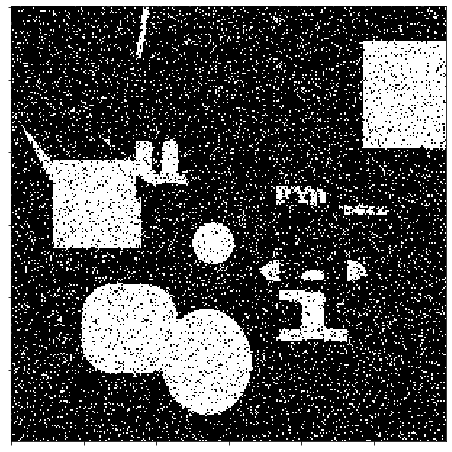

In [28]:
show_image(reducer_result.reduced_image)

## GradientBasedBinaryNoiseReducer

In [43]:
class BucketBasedSampler(object):
    def __init__(self):
        self._buckets = defaultdict(list)
        self._positions = {}

    def remove_key_if_exists(self, key):
        if key not in self._positions:
            return
        bucket_key, index_in_bucket  = self._positions[key]
        del self._positions[key]
        bucket = self._buckets[bucket_key]
        bucket[index_in_bucket], bucket[-1] = bucket[-1], bucket[index_in_bucket]
        bucket.pop()
        if len(bucket) > index_in_bucket:
            self._positions[bucket[index_in_bucket]] = (bucket_key, index_in_bucket)
        elif len(bucket) == 0:
            del self._buckets[bucket_key]

    def get_value(self, key):
        return self._positions[key][0]
        
    def set_value(self, key, value):
        self.remove_key_if_exists(key)
        self._buckets[value].append(key)
        self._positions[key] = (value, len(self._buckets[value]) - 1)
    
    def sample_key(self):
        bucket_index_to_key = dict(enumerate(self._buckets.keys()))
        bucket_probs = np.zeros(shape=(len(self._buckets), ))
        for bucket_index, bucket_key in bucket_index_to_key.items():
            bucket_probs[bucket_index] = bucket_key * len(self._buckets[bucket_key])
        bucket_probs /= np.sum(bucket_probs)
        sampled_bucket_index = np.random.choice(len(self._buckets), p=bucket_probs)
        sampled_bucket = self._buckets[bucket_index_to_key[sampled_bucket_index]]
        key_index = np.random.randint(low=0, high=len(sampled_bucket))
        return sampled_bucket[key_index]

In [35]:
class GradientBasedBinaryNoiseReducer(SupervisedNoiseReducer):
    def __init__(
        self, noise_level_prior, observation_strength,
        coupling_strength, temperature, **kwargs
    ):
        super(GradientBasedBinaryNoiseReducer, self).__init__(**kwargs)        
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength
        self._temperature = temperature
        self.neighbours_sampler = None

    @staticmethod
    def _get_opposite_value(value):
        if value == 1.0:
            return -1.0
        elif value == -1.0:
            return 1.0
        else:
            raise ValueError(f"Invalid value: {value}")
    
    def _get_state_potential(self, observation_value, state_value):
        if observation_value == state_value:
            return self._observation_strength * np.log(1.0 - self._noise_level_prior)
        return self._observation_strength * np.log(self._noise_level_prior)

    def _update_sampler_state(self, row, column, current_state, observation_value, next_value):
        if row <= 0 or row >= current_state.shape[0] - 1:
            return
        if column <= 0 or column >= current_state.shape[1] - 1:
            return
        neighbours_sum = np.sum([
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ])
        current_value = current_state[row, column]
        values_difference = next_value - current_value
        coupling_potential = values_difference * self._coupling_strength * neighbours_sum
        next_state_potential = self._get_state_potential(observation_value, next_value)
        current_state_potential = self._get_state_potential(observation_value, current_value)
        state_potential = next_state_potential - current_state_potential
        total_potential = np.exp(self._temperature * (coupling_potential + state_potential))
        self.neighbours_sampler.set_value(key=(row, column), value=total_potential)
        
    def _preprocess(self, observation):
        self.neighbours_sampler = BucketBasedSampler()
        for row in range(observation.shape[0]):
            for column in range(observation.shape[1]):
                observation_value = observation[row, column]
                next_value = self._get_opposite_value(observation_value)
                self._update_sampler_state(
                    row, column, observation, observation_value, next_value,
                )

    def _value_accepted(self, value):
        return np.random.uniform() <= value ** (self._temperature - 2.0)        

    def _sampler_step(self, observation, current_state):
        sampled_key = self.neighbours_sampler.sample_key()
        sampled_value = self.neighbours_sampler.get_value(sampled_key)
        if not self._value_accepted(sampled_value):
            return
        sampled_row, sampled_column = sampled_key
        current_state[sampled_row, sampled_column] = self._get_opposite_value(
            current_state[sampled_row, sampled_column]
        )
        positions_to_update = [
            (sampled_row, sampled_column), (sampled_row - 1, sampled_column),
            (sampled_row + 1, sampled_column), (sampled_row, sampled_column - 1),
            (sampled_row, sampled_column + 1),
        ]
        for row, column in positions_to_update:
            observation_value = observation[row, column]
            next_value = self._get_opposite_value(current_state[row, column])
            self._update_sampler_state(
                row, column, current_state, observation_value, next_value,
            )

2.3081469535827637


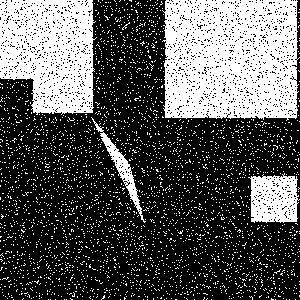

In [53]:
reducer = GradientBasedBinaryNoiseReducer(
    noise_level_prior=0.15,
    observation_strength=1.0,
    coupling_strength=4.0,
    iterations_count=1000,
    iterations_per_evaluation=50_000,
    temperature = 2.0
)
s = time.time()
reducer_result = reducer.reduce_noise(BINARY_IMAGE_GROUND_TRUTH, BINARY_IMAGE_OBSEVATION)
print(time.time() - s)
reducer.average_statistics.evaluation_losses
PIL.Image.fromarray(reducer_result.reduced_image.astype(np.uint8))

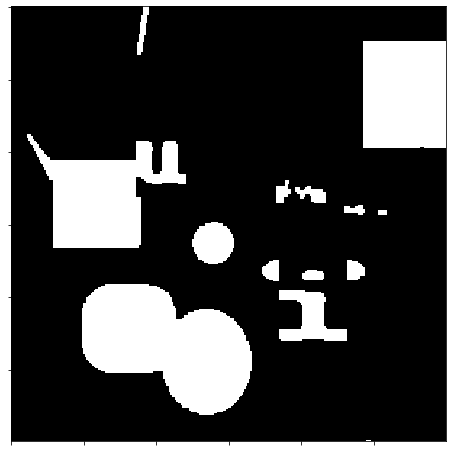

In [30]:
show_image(reducer_result.reduced_image)

## GrayscaleGibbsNoiseReducer

In [54]:
class GrayscaleGibbsNoiseReducer(SupervisedNoiseReducer):
    def __init__(self, noise_level_prior, observation_strength, coupling_strength, **kwargs):
        super(GrayscaleGibbsNoiseReducer, self).__init__(**kwargs)        
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength

    def _get_state_potential(self, observation_value, state_value):
        if (observation_value > 0) == (state_value > 0):
            return self._observation_strength * np.log(1.0 - self._noise_level_prior)
        return self._observation_strength * np.log(self._noise_level_prior)

    def _get_potential(self, observation_value, state_value, neighbours_values):
        coupling_potential = self._coupling_strength * -np.sum([
            abs(state_value - neighbour_value) for neighbour_value in neighbours_values
        ])        
        state_potential = self._get_state_potential(observation_value, state_value)
        return np.exp(coupling_potential + state_potential)

    def _sampler_step(self, observation, current_state):
        row = np.random.randint(low=1, high=(current_state.shape[0] - 1))
        column = np.random.randint(low=1, high=(current_state.shape[1] - 1))
        neighbours_values = [
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ]
        negative_value = -abs(current_state[row, column])
        negative_potential = self._get_potential(
            observation[row, column], negative_value, neighbours_values
        )
        positive_value = abs(current_state[row, column])
        positive_potential = self._get_potential(
            observation[row, column], positive_value, neighbours_values        
        )
        positive_pbty = positive_potential / (negative_potential + positive_potential)
        if np.random.uniform() <= positive_pbty:
            current_state[row, column] = positive_value
        else:
            current_state[row, column] = negative_value

In [57]:
reducer = GrayscaleGibbsNoiseReducer(
    noise_level_prior=0.1,
    observation_strength=1.0,
    coupling_strength=4.0,
    iterations_count=5_000_000,
    iterations_per_evaluation=10_000,
)
reducer_result = reducer.reduce_noise(
    GRAYSCALE_IMAGE_GROUND_TRUTH, GRAYSCALE_IMAGE_OBSERVATION
)
reducer_result.statistics.evaluation_losses[-1]

3.092033

## GradientBasedGrayscaleNoiseReducer

In [100]:
class GradientBasedGrayscaleNoiseReducer(SupervisedNoiseReducer):
    def __init__(
        self, noise_level_prior, observation_strength,
        coupling_strength, temperature, **kwargs
    ):
        super(GradientBasedGrayscaleNoiseReducer, self).__init__(**kwargs)        
        self._noise_level_prior = noise_level_prior
        self._observation_strength = observation_strength
        self._coupling_strength = coupling_strength
        self._temperature = temperature
        self.neighbours_sampler = None

    def _get_state_potential(self, observation_value, state_value):
        if observation_value == state_value:
            return self._observation_strength * np.log(1.0 - self._noise_level_prior)
        return self._observation_strength * np.log(self._noise_level_prior)

    def _update_sampler_state(self, row, column, current_state, observation_value, next_value):
        if row <= 0 or row >= current_state.shape[0] - 1:
            return
        if column <= 0 or column >= current_state.shape[1] - 1:
            return
        neighbours_values = [
            current_state[row - 1, column], current_state[row + 1, column],
            current_state[row, column - 1], current_state[row, column + 1],
        ]
        current_value = current_state[row, column]
        coupling_potential = self._coupling_strength * -np.sum([
            abs(next_value - neighbour_value) - abs(current_value - neighbour_value)  
            for neighbour_value in neighbours_values
        ])        
        next_state_potential = self._get_state_potential(observation_value, next_value)
        current_state_potential = self._get_state_potential(observation_value, current_value)
        state_potential = next_state_potential - current_state_potential
        total_potential = np.exp(round(self._temperature * (coupling_potential + state_potential)))
        self.neighbours_sampler.set_value(key=(row, column), value=total_potential)
        
    def _preprocess(self, observation):
        self.neighbours_sampler = BucketBasedSampler()
        for row in range(observation.shape[0]):
            for column in range(observation.shape[1]):
                observation_value = observation[row, column]
                next_value = -observation_value
                self._update_sampler_state(
                    row, column, observation, observation_value, next_value,
                )

    def _value_accepted(self, value):
        return np.random.uniform() <= value ** (self._temperature - 2.0)        

    def _sampler_step(self, observation, current_state):
        sampled_key = self.neighbours_sampler.sample_key()
        sampled_value = self.neighbours_sampler.get_value(sampled_key)
        if not self._value_accepted(sampled_value):
            return
        sampled_row, sampled_column = sampled_key
        current_state[sampled_row, sampled_column] = -current_state[sampled_row, sampled_column]
        positions_to_update = [
            (sampled_row, sampled_column), (sampled_row - 1, sampled_column),
            (sampled_row + 1, sampled_column), (sampled_row, sampled_column - 1),
            (sampled_row, sampled_column + 1),
        ]
        for row, column in positions_to_update:
            observation_value = observation[row, column]
            next_value = -current_state[row, column]
            self._update_sampler_state(
                row, column, current_state, observation_value, next_value,
            )

In [109]:
reducer = GradientBasedGrayscaleNoiseReducer(
    noise_level_prior=0.1,
    observation_strength=1.0,
    coupling_strength=4.0,
    temperature=2.0,
    iterations_count=300_000,
    iterations_per_evaluation=10_000,
)
import time
s = time.time()
reducer_result = reducer.reduce_noise(
    GRAYSCALE_IMAGE_GROUND_TRUTH, GRAYSCALE_IMAGE_OBSERVATION
)
print(time.time() - s)
reducer_result.statistics.evaluation_losses[-1]

225.88972187042236


0.2091784

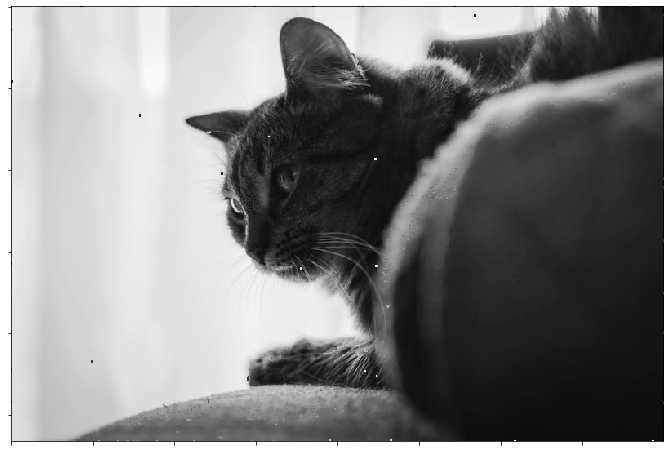

In [110]:
show_image(reducer_result.reduced_image)

In [111]:
reducer_result.statistics.evaluation_losses

[25.71722,
 21.810368,
 18.454369,
 14.334894,
 10.381119,
 6.7122254,
 3.6787782,
 1.9020385,
 1.3836617,
 1.0635773,
 0.8334464,
 0.6381185,
 0.53244776,
 0.4300228,
 0.3630106,
 0.32487735,
 0.30003214,
 0.27790737,
 0.25246647,
 0.24866718,
 0.24449272,
 0.2393473,
 0.23412211,
 0.23057616,
 0.2304073,
 0.22314651,
 0.2227572,
 0.22088572,
 0.22029473,
 0.2091784]

In [108]:
len(reducer.neighbours_sampler._buckets)

62

In [80]:
reducer.neighbours_sampler._buckets.keys()

dict_keys([5.403382486915744e-30, 2.582797432327834e-16, 3.7082225722968334e-30, 3.270897426277482e-30, 2.0095174483051742e-16, 2.009513615458472e-16, 0.012345679012345685, 4.204018913959427e-30, 2.278193715695389e-16, 1.7725204590340937e-16, 0.01399634624296958, 0.010889684181143475, 3.708236718070321e-30, 4.204034951049471e-30, 2.9281278982033645e-16, 2.928133483169434e-16, 6.1258482698929114e-30, 6.1258249016808376e-30, 3.319630444463197e-16, 8.926156493123524e-30, 3.319624112776646e-16, 6.944912213158884e-30, 6.944885720471786e-30, 4.7661223415215555e-30, 1.7725238398517922e-16, 1.0119600427007274e-29, 3.7634784650522006e-16, 1.4745628304616013e-29, 4.2666707616612513e-16, 1.1472653827098343e-29, 1.1472697591883001e-29, 1.6717146579587505e-29, 4.837141904082212e-16, 2.435914654480884e-29, 5.483887346188852e-16, 5.48389780588386e-16, 4.837132677975014e-16, 1.8952332858184572e-29, 2.928122313247947e-16, 0.015867714360400176, 2.761601031376507e-29, 6.217105270430596e-16, 4.02402670224